# Part 2 - Data and Model Visualization

## Task a)

### import required libraries and assert constraints

In [5]:
import sys
assert sys.version_info >= (3, 5) # make sure we have Python 3.5+

from pyspark.sql import SparkSession, functions, types
assert spark.version >= '2.4' # make sure we have Spark 2.4+
from pyspark.ml import PipelineModel
from pyspark.ml.evaluation import RegressionEvaluator

import pandas as pd
import geoviews as gv
import geoviews.feature as gf
import plotly.graph_objects as go
import matplotlib.pyplot as plt


spark = SparkSession.builder.appName('Weather Prediction').getOrCreate()
spark.sparkContext.setLogLevel('WARN')

### read data using spark and return a pandas dataframe

In [6]:
tmax_schema = types.StructType([
    types.StructField('station', types.StringType()),
    types.StructField('date', types.DateType()),
    types.StructField('latitude', types.FloatType()),
    types.StructField('longitude', types.FloatType()),
    types.StructField('elevation', types.FloatType()),
    types.StructField('tmax', types.FloatType()),
])

def get_data(input_path):
    df_base = spark.read.csv(input_path, schema=tmax_schema)
    return df_base.toPandas()

### function to return data for a specific year

In [7]:
def get_data_for_year(df_input, year, span):
    df_input['year'] = df_input['date'].apply(lambda date: str(date).split('-')[0])
    df_filtered = df_input.loc[(df_input['year'] >= str(year - span)) & (df_input['year'] <= str(year + span))]
    df_grouped = df_filtered.groupby(['station'], as_index=False).max()
    df_grouped['label'] = df_grouped['station'] + '<br>' + df_grouped['tmax'].map(str)
    return df_grouped

### function to plot temperature distribution map

In [21]:
def plot_map(df, map_title, marker_color_col, use_default_marker = True, default_marker_size = 5, marker_size_col = ''):
    
    if (use_default_marker):
        df['markersize'] = default_marker_size
    else:
        df['markersize'] = df[marker_size_col]
        
    color_scale = [0,"blue"],[0.5, "white"],[1,"red"]

    fig = go.Figure(data=go.Scattergeo(
        lat = df['latitude'],
        lon = df['longitude'],
        text = df['label'],
        marker = dict(
            color = df[marker_color_col],
            colorscale = 'icefire',
            #reversescale = True,
            opacity = 0.5,
            size = df['markersize'],
            colorbar = dict(
                titleside = "right",
                outlinecolor = "rgba(68, 68, 68, 0)",
                ticks = "outside",
                showticksuffix = "last",
                #dtick = 0.1,
            ),
            cmin=-50,
            cmax=+50
        )
    ))

    fig.update_layout(
        geo = dict(
            scope = 'world',
            showland = True, landcolor = "LightGray",
            subunitcolor = "rgb(255, 255, 255)",
            showlakes = True, lakecolor = "Blue",
            showocean = True, oceancolor='LightBlue',
            showsubunits = True,
            showcountries = True, countrycolor='RebeccaPurple',
            resolution = 110,
            projection = dict(
                type = 'miller'
            ),
            fitbounds = 'geojson',
            lonaxis = dict(
                showgrid = True,
                gridwidth = 0.35,
                range= [ -140.0, -55.0 ],
                dtick = 2
            ),
            lataxis = dict (
                showgrid = True,
                gridwidth = 0.35,
                range= [ 20.0, 60.0 ],
                dtick = 2
            )
        ),
                    width = 900,
            height = 700,
        title='<b>' + map_title + '</b>',
    )
    fig.show()

### declare variables used in the code

In [9]:
input_path = 'tmax-2'
weather_model_name = 'weather_model'
year1 = 2000
year2 = 2015

### get data and plot for years 1980 and 2015

In [10]:
df_base = get_data(input_path)
print("# of records: %d" % len(df_base))

df_year1 = get_data_for_year(df_base, year1, 1)
print("# of records in year %d: %d" % (year1, len(df_year1)))

df_year2 = get_data_for_year(df_base, year2, 1)
print("# of records in year %d: %d" % (year2, len(df_year2)))

# of records: 180664
# of records in year 2000: 258
# of records in year 2015: 238


In [25]:
plot_map(df_year1, 'Temperature Distribution, Year=' + str(year1), marker_color_col='tmax', default_marker_size=10)

In [26]:
plot_map(df_year2, 'Temperature Distribution, Year=' + str(year2), marker_color_col='tmax', default_marker_size=10)

## Task b

### b1)

### function to load pre-trained model

In [16]:
def test_model(model_file, inputs, break_data):
    # get the data
    data = spark.read.csv(inputs, schema=tmax_schema)
    
    # break data to train and test set
    train, test = data.randomSplit([0.7, 0.3]) #Needed for 733 A3
    
    # load the model
    test_model = PipelineModel.load(model_file)
    
    # use the model to make predictions
    if (break_data):
        predictions = test_model.transform(test)
    else:
        predictions = test_model.transform(data)
    
    # return predictions
    return predictions.toPandas()

### function to convert result dataframe to default schema

In [17]:
def normal_df_schema(df):
    df['tmax'] = df['prediction']
    df = df.drop(columns=['features', 'prediction'])
    
    return df

### get data and plot predictions

In [19]:
predictions = test_model(weather_model_name, input_path, False)

df_predictions = normal_df_schema(predictions)

df_pred_year1 = get_data_for_year(df_predictions, year1, 2)
print("# of records in year %d: %d" % (year1, len(df_year1)))

df_pred_year2 = get_data_for_year(df_predictions, year2, 2)
print("# of records in year %d: %d" % (year2, len(df_year2)))

# of records in year 2000: 258
# of records in year 2015: 238


In [21]:
plot_map(df_pred_year1, 'Distribution of Temperature in Year 2000', marker_color_col='tmax', default_marker_size=10)
plot_map(df_pred_year2, 'Distribution of Temperature in Year 2015', marker_color_col='tmax', default_marker_size=10)

### function to compute errors between real and predicted temperature

In [22]:
def calc_errors(df_predictions):

    df_predictions['error'] = abs(df_predictions['prediction'] - df_predictions['tmax'])

    df_predictions['label'] = 'Station: ' + df_predictions['station'] + \
                            '<br>Error: ' + df_predictions['error'].apply(str) + \
                            '<br>Real: ' + df_predictions['tmax'].apply(str) + \
                            '<br>Predicted: ' + df_predictions['prediction'].apply(str) 
    
    return df_predictions

### plot errors on map

In [39]:
new_predictions = test_model(weather_model_name, input_path, True)

df_year1 = get_data_for_year(new_predictions, year1, 2)

df_errors = calc_errors(df_year1)

plot_map(df_errors, 'Temperature Prediction Error - Year =' + str(year1), marker_color_col='error', use_default_marker=False, marker_size_col='error')

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W

:Overlay
   .Points.I    :Points   [longitude,latitude]   (prediction)
   .Coastline.I :Feature   [Longitude,Latitude]
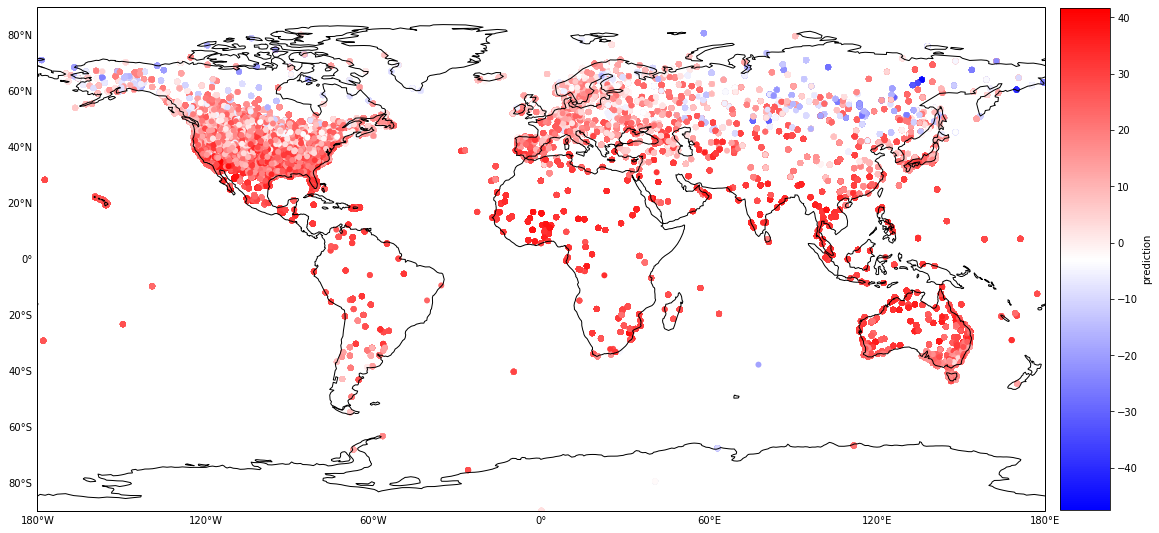

<Figure size 864x432 with 0 Axes>

In [44]:
gv.extension('matplotlib')

gdp = gv.Dataset(predictions, kdims=['prediction'])
points = gdp.to(gv.Points, ['longitude', 'latitude'], ['prediction'])

tiles = gv.tile_sources.Wikipedia

plt.figure(figsize=(12,6))
gv.output(
points.opts(
        color='prediction', 
        colorbar=True, 
        cmap='bwr',
        global_extent=True,
        backend='matplotlib', 
        fig_size=500) * gf.coastline, backend='matplotlib')